In [1]:
import torch
from torch import nn
from torchvision import transforms
from pathlib import Path
from PIL import Image
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'cuda'

## Load data

In [3]:
IMAGE_DIR = "../data"

In [4]:
image_path = Path(IMAGE_DIR)

In [5]:
path_classes = [ d for d in image_path.iterdir() if d.is_dir() and not d.name.startswith('.')]

In [6]:
samples = []
for path in path_classes:
    files = list(path.glob('*.png'))
    for file in files:
        samples.append((file , 1.0 if path.name == "cat" else 0.0))

In [7]:
transform = transforms.ToTensor()

In [8]:
random.shuffle(samples)

In [9]:
X = torch.zeros(len(samples),3,128,128)
y = torch.zeros(len(samples))

In [10]:
for idx in range(len(samples)):
    X[idx] = transform(Image.open(samples[idx][0]).resize((128,128)))
    y[idx] = samples[idx][1]

Above code loads images from IMAGE_DIR, shuffles the samples and then creates corresponding tensors. X for data and y for lables. In the lables 1.0 means cat and 0.0 means dog

In [22]:
len(y)

1544

## Build the model

In [12]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=3*128*128,out_features=16*16),
            nn.ReLU(),
            nn.Linear(in_features=16*16,out_features=16*16),
            nn.ReLU(),
            nn.Linear(in_features=16*16,out_features=1)
        )
    def forward(self, x, **kwargs):
        x = x.view(x.size(0), -1)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
model = MyNN()
model.to(device)

MyNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=49152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

### Setup training loop

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [16]:
percentage = 0.8
split_index = int(len(X)*percentage)
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [17]:
EPOCHS = 500

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_acc = 0

    total_test_loss = 0
    total_test_acc = 0
    
    for X_batch, y_batch in train_loader:
        y_logits = model(X_batch).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))
        loss = loss_fn(y_logits, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += accuracy_fn(y_batch, y_pred)

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_acc = total_acc / len(train_loader)
    train_accs.append(avg_acc)
    model.eval()

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            test_logits = model(X_batch).squeeze()
            test_y_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_batch)

            total_test_loss += test_loss.item()
            total_test_acc += accuracy_fn(y_batch, test_y_pred)
            
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    avg_test_acc = total_test_acc / len(test_loader)
    test_accs.append(avg_test_acc)
    if (epoch % 50 == 0) or (epoch == EPOCHS-1):
        print(f"Epoch {epoch} | Average Loss: {avg_loss:.5f} - Average Acc: {avg_acc:.2f}% | Average Test Loss: {avg_test_loss:.5f} - Average Test Acc: {avg_test_acc:.2f}%")

Epoch 0 | Average Loss: 0.69456 - Average Acc: 49.62% | Average Test Loss: 0.69145 - Average Test Acc: 51.80%
Epoch 50 | Average Loss: 0.69045 - Average Acc: 54.13% | Average Test Loss: 0.69095 - Average Test Acc: 56.37%
Epoch 100 | Average Loss: 0.68847 - Average Acc: 60.73% | Average Test Loss: 0.69033 - Average Test Acc: 59.32%
Epoch 150 | Average Loss: 0.68557 - Average Acc: 61.29% | Average Test Loss: 0.68910 - Average Test Acc: 58.69%
Epoch 200 | Average Loss: 0.68311 - Average Acc: 65.75% | Average Test Loss: 0.68822 - Average Test Acc: 57.59%
Epoch 250 | Average Loss: 0.68027 - Average Acc: 65.16% | Average Test Loss: 0.68750 - Average Test Acc: 57.72%
Epoch 300 | Average Loss: 0.67631 - Average Acc: 66.15% | Average Test Loss: 0.68552 - Average Test Acc: 57.14%
Epoch 350 | Average Loss: 0.67189 - Average Acc: 67.30% | Average Test Loss: 0.68476 - Average Test Acc: 57.44%
Epoch 400 | Average Loss: 0.66699 - Average Acc: 69.33% | Average Test Loss: 0.68475 - Average Test Acc: 54

## Check accuracy of model

In [18]:
acc_dataset = TensorDataset(X.to(device), y.to(device))
acc_loader = DataLoader(dataset=acc_dataset, batch_size=32, shuffle=True)

In [19]:
model.eval()
total_acc = 0
with torch.inference_mode():
    for X_batch, y_batch in acc_loader:
        test_logits = model(X_batch).squeeze()
        test_y_pred = torch.round(torch.sigmoid(test_logits))
        total_acc += accuracy_fn(y_batch, test_y_pred)
acc = total_acc / len(acc_loader)

In [20]:
print(f"The model performs with an accuracy of: {acc:.2f}% on the whole dataset")

The model performs with an accuracy of: 68.75% on the whole dataset


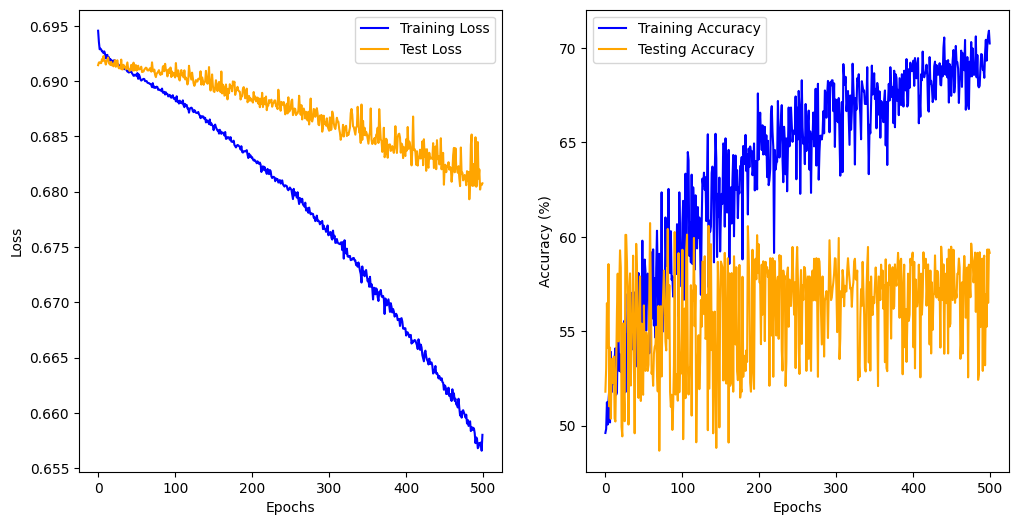

In [27]:
epochs = range(EPOCHS)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(epochs, train_losses, color = 'blue', label = "Training Loss")
ax1.plot(epochs, test_losses, color = 'orange', label = "Test Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs, train_accs, color = 'blue', label = "Training Accuracy")
ax2.plot(epochs, test_accs, color = 'orange', label = "Testing Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()